### Import

In [8]:
import os

In [9]:
import numpy as np
import pandas as np

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
from IPython.display import display
from PIL import Image

In [20]:
from keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

### Data preparation

In [12]:
# dimensions of our images.
img_width, img_height = 224, 224

In [13]:
epochs = 20
batch_size = 16

In [15]:
DATA_PATH = 'data'

In [16]:
train_data_dir = os.path.join(DATA_PATH, 'train')
validation_data_dir = os.path.join(DATA_PATH, 'validation')
test_data_dir = os.path.join(DATA_PATH, 'test')

nb_train_samples = len(os.listdir(os.path.join(DATA_PATH, 'train/dog'))) + len(os.listdir(os.path.join(DATA_PATH, 'train/cat')))
nb_validation_samples = len(os.listdir(os.path.join(DATA_PATH, 'validation/dog'))) + len(os.listdir(os.path.join(DATA_PATH, 'validation/cat')))

In [19]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [24]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

In [25]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [26]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 20000 images belonging to 2 classes.


In [27]:
validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 2500 images belonging to 2 classes.


In [28]:
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 2500 images belonging to 2 classes.


### Define model

In [21]:
# define cnn model
def define_model():
    # load model
    model = VGG16(include_top=False, input_shape=(224, 224, 3))
    # mark loaded layers as not trainable
    for layer in model.layers:
        layer.trainable = False
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
    output = Dense(1, activation='sigmoid')(class1)
    # define new model
    model = Model(inputs=model.inputs, outputs=output)
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [22]:
model = define_model()

Instructions for updating:
Colocations handled automatically by placer.


In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [29]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
1250/1250 [==============================] - 7003s 6s/step - loss: 0.3454 - acc: 0.8427 - val_loss: 0.2392 - val_acc: 0.8962
Epoch 2/20
1250/1250 [==============================] - 6947s 6s/step - loss: 0.2360 - acc: 0.8984 - val_loss: 0.1728 - val_acc: 0.9279
Epoch 3/20
1250/1250 [==============================] - 6959s 6s/step - loss: 0.2100 - acc: 0.9109 - val_loss: 0.1883 - val_acc: 0.9147
Epoch 4/20
1250/1250 [==============================] - 6971s 6s/step - loss: 0.2067 - acc: 0.9154 - val_loss: 0.1897 - val_acc: 0.9243
Epoch 5/20
1250/1250 [==============================] - 6965s 6s/step - loss: 0.1940 - acc: 0.9190 - val_loss: 0.1619 - val_acc: 0.9348
Epoch 6/20
1250/1250 [==============================] - 6963s 6s/step - loss: 0.1853 - acc: 0.9220 - val_loss: 0.1617 - val_acc: 0.9348
Epoch 7/20
1250/1250 [==============================] - 6975s 6s/step - loss: 0.1826 - acc: 0.9224 - val_loss: 0.1643 - val_acc: 0.9332


### Model evaluation

In [30]:
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size
scores = model.evaluate_generator(test_generator, steps=STEP_SIZE_TEST)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


acc: 94.27%


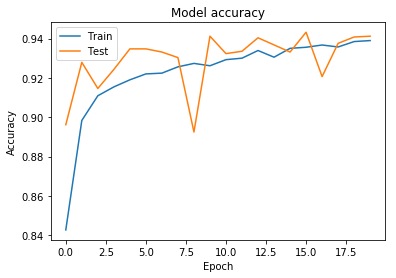

In [31]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

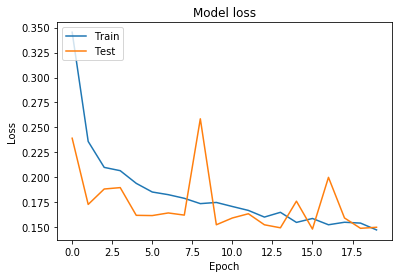

In [32]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()